In [1]:
########################################################################
# Service version : 1.2.2
# Language        : Python/Jupyter

## Mixture-Model based Anomaly Detection in Multivariate Time Series Data

This service end points aims to identify structures and modes in the operation of an asset. A user can feed into our model, a historical record of an asset operating in a normal fashion. After we train our model on the input variables specified by feature columns, we can identify the different modes of normal operation, and an expected range of readings from the
IoT sensors. The service provide an automated way of discovering the best mixture model parameters. Once we have trained our model, we can apply it to a new record of data to Identify the mode in which our asset is currently operating.

The workflow of this notebook is as follows: <br>

1. [Provide Credential.](#packageLoad)
2. [Load Dataset.](#dataLoad)
3. [Compose Anomaly Service and Submit Job.](#pipelineCreation)
4. [Monitor Job](#thresholdstats)
5. [Result Analysis](#groundtruth)

### Credentials

This notebook requires two credentials. Please obtain your own credentials when customizing this notebook for your own work. Please visit __[Anomaly Detection @ IBM](https://developer.ibm.com/apis/catalog/ai4industry--anomaly-detection-product/Introduction)__ for trial subscription.

In [32]:
# Credentials required for running notebook

Client_ID = "---"
Client_Secret = "---"


### Load Dataset<a id="dataLoad"></a>

In the data below, we have preselecteded certain columns to build mixture model. The actual meaning of the values isn't that important for the purpose of this example.

In [34]:
# try reading datasets from local files
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

datafile_name = 'credit_card_subset_mixturemodel_X_tiny.csv'
datafile_dir = './datasets/multivariate/sample_data/'
data_df = pd.read_csv(datafile_dir + datafile_name)

data_df.head(10)

,V17,V14,V11,V4,V15,V13,time_column
0,0.207971,-0.311169,-0.551600,1.378155,1.468177,-0.991390,0.0
1,-0.114805,-0.143772,1.612727,0.448154,0.635558,0.489095,1.0
2,1.109969,-0.165946,0.624501,0.379780,2.345865,0.717293,2.0
3,-0.684093,-0.287924,-0.226487,-0.863291,-0.631418,0.507757,3.0
4,-0.237033,-1.119670,-0.822843,0.403034,0.175121,1.345852,4.0
5,-0.058133,-0.137134,1.341262,-0.168252,0.517617,-0.358091,5.0
6,0.002821,0.167372,-1.416907,1.202613,0.050144,-0.751063,6.0
7,-1.222127,-1.323865,-0.619468,-0.492199,0.686133,1.757964,7.0
8,-0.499768,0.074355,-0.705117,-0.271526,-0.328783,-0.286254,8.0
9,-0.540980,-0.443523,1.017614,-0.222187,0.150219,1.006844,9.0


Below plot shows the sensor data for each of the variables, the user can also choose/resample data based upon the domain knowledge.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

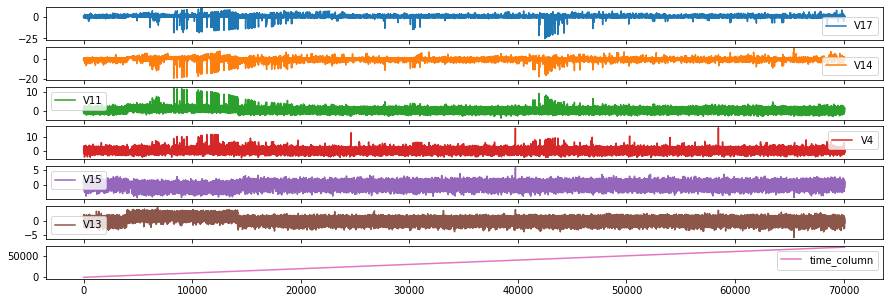

In [35]:
data_df.plot(subplots=True, figsize=(15, 5))

### Anomaly Service Creation and Job Submission <a id="pipelineCreation"></a>

Now, we compose anomaly service. User need to provide a local file name and some meta-data information about the data (target_column, time_column, time_format, etc). The detail of these parameters are available at __[IBM API Hub @ IBM](https://developer.ibm.com/apis/catalog/ai4industry--anomaly-detection-product/api/API--ai4industry--anomaly-detection-api#batch_uni)__ for Univariate Anomaly detection service.

Note that, file size is large. You are requested to put the data on IBM COS.

In [36]:
import numpy as np

feature_columns = ['V17', 'V14', 'V11', 'V4', 'V15', 'V13']
time_column = "time_column"

In [37]:
# setting the path and file location onto cloud - for large
#datafile_dir = './'
#datafile_name = 'sample_file.json'

file_path = datafile_dir + datafile_name

files = {'data_file': (datafile_name, open(file_path, 'rb'))}
data = {
    'feature_columns': str(feature_columns),
    'dag_type': 'Minimal',
    'evaluation_time': 3,
}

headers = {
    'X-IBM-Client-Id': Client_ID,
    'X-IBM-Client-Secret': Client_Secret,
    'accept': "application/json",
    }

import requests
post_response = requests.post("https://api.ibm.com/ai4industry/run/anomaly-detection/timeseries/mixture-based/model", 
                              data=data,
                              files=files,
                              headers=headers)

post_r_json = post_response.json()
anomaly_service_jobId = None
if 'jobId' in post_r_json:
    anomaly_service_jobId = post_r_json['jobId']
    print ('submitted successfully job : ', post_r_json['jobId'])
else:
    print (post_r_json)

submitted successfully job :  0ce71484-7956-43f5-890a-75011887f8cb


### Monitor Anomaly Job <a id="pipelineCreation"></a>

Each anomaly detection service call generates one job id. We now track the progress of job. Detail of job execution is covered at __[Get Result](https://developer.ibm.com/apis/catalog/ai4industry--anomaly-detection-product/api/API--ai4industry--anomaly-detection-api#get_result_by_id)__. You may need to the following cell at periodic interval.

In [45]:
get_response = requests.get("https://api.ibm.com/ai4industry/run/result/" + anomaly_service_jobId, headers=headers)
json_data = get_response.json()

print("the status of job {} is {}.".format(anomaly_service_jobId, json_data['status']))

the status of job 0ce71484-7956-43f5-890a-75011887f8cb is executing.


### Anomaly Results <a id="groundtruth"></a>

Now we plot the anomaly score and anomaly label detected by the service.

In [31]:
# TBA